# Introduction

<div class="alert alert-block alert-warning">
<font color=black><br>

**What?** Hourly Time Series Forecasting using XGBoost

<br></font>
</div>

# Import modules

In [67]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl

rcParams['figure.figsize'] = 17, 8
rcParams['font.size'] = 20

# Load the dataset

<div class="alert alert-block alert-info">
<font color=black><br>

- The data we will be using is hourly power consumption data from PJM

<br></font>
</div>

In [3]:
pjme = pd.read_csv('../DATASETS/PJME_hourly.csv', index_col=[0], parse_dates=[0])

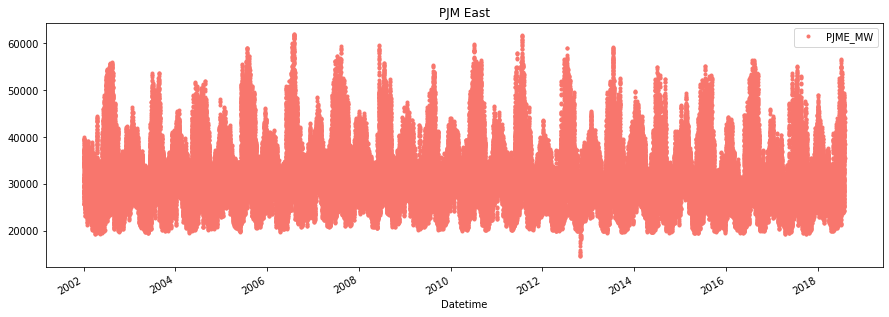

In [6]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

# Split the data

<div class="alert alert-block alert-info">
<font color=black><br>

- Cut off the data after 2015 to use as our validation set.

<br></font>
</div>

In [7]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

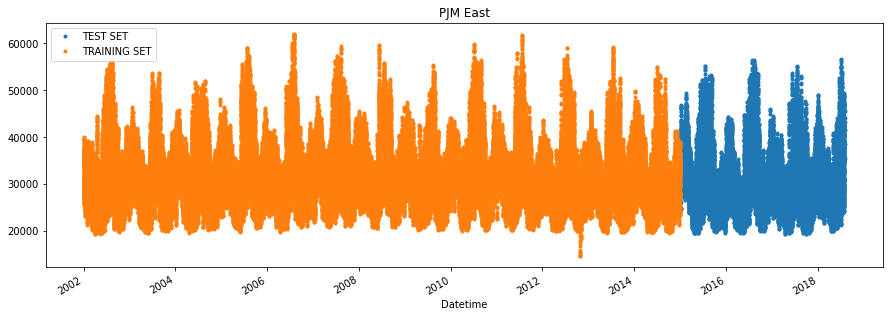

In [8]:
_ = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

# Create time series features

In [54]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    #df['weekofyear'] = df['date'].dt.weekofyear deprecated!
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
        
    
    if label:
        y = df[label]
        return X, y
    return X

In [61]:
X_train, y_train = create_features(pjme_train, label='PJME_MW')
X_test, y_test = create_features(pjme_test, label='PJME_MW')

# We have to change the type otherwise XGBoost will complain
X_train = X_train.astype("float")
X_test = X_test.astype("float")

In [62]:
X_train["weekofyear"].unique()

array([ 1., 52., 51., 50., 49., 48., 47., 46., 45., 44., 43., 42., 41.,
       40., 39., 38., 37., 36., 35., 34., 33., 32., 31., 30., 29., 28.,
       27., 26., 25., 24., 23., 22., 21., 20., 19., 18., 17., 16., 15.,
       14., 13., 12., 11., 10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.,  2.,
       53.])

In [63]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 113927 entries, 2002-12-31 01:00:00 to 2014-01-02 00:00:00
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   hour        113927 non-null  float64
 1   dayofweek   113927 non-null  float64
 2   quarter     113927 non-null  float64
 3   month       113927 non-null  float64
 4   year        113927 non-null  float64
 5   dayofyear   113927 non-null  float64
 6   dayofmonth  113927 non-null  float64
 7   weekofyear  113927 non-null  float64
dtypes: float64(8)
memory usage: 11.9 MB


# Create XGBoost model

In [64]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds = 50,
       verbose = True)

[14:20:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:29710.4	validation_1-rmse:28762.5
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:26822.6	validation_1-rmse:25892.2
[2]	validation_0-rmse:24211.2	validation_1-rmse:23286.6
[3]	validation_0-rmse:21885	validation_1-rmse:20967.5
[4]	validation_0-rmse:19780.3	validation_1-rmse:18868.5
[5]	validation_0-rmse:17910	validation_1-rmse:17017.7
[6]	validation_0-rmse:16216.1	validation_1-rmse:15336.4
[7]	validation_0-rmse:14717.8	validation_1-rmse:13861.5
[8]	validation_0-rmse:13377.4	validation_1-rmse:12536.3
[9]	validation_0-rmse:12184.1	validation_1-rmse:11362.1
[10]	validation_0-rmse:11099.4	validation_1-rmse:10298.7
[11]	validation_0-rmse:10135.2	validation_1-rmse:9357.58
[12]	validation_0-rmse:9294.73	validation_1-rmse:8555.9

[140]	validation_0-rmse:2939.16	validation_1-rmse:3719.24
[141]	validation_0-rmse:2935.64	validation_1-rmse:3715.27
[142]	validation_0-rmse:2934.18	validation_1-rmse:3715.1
[143]	validation_0-rmse:2933.73	validation_1-rmse:3715.9
[144]	validation_0-rmse:2933.1	validation_1-rmse:3715.75
[145]	validation_0-rmse:2932.23	validation_1-rmse:3716.29
[146]	validation_0-rmse:2931.2	validation_1-rmse:3717.22
[147]	validation_0-rmse:2930.35	validation_1-rmse:3718.02
[148]	validation_0-rmse:2928.75	validation_1-rmse:3717.76
[149]	validation_0-rmse:2923.14	validation_1-rmse:3712.2
[150]	validation_0-rmse:2920.09	validation_1-rmse:3714.78
[151]	validation_0-rmse:2919.09	validation_1-rmse:3714.25
[152]	validation_0-rmse:2918.28	validation_1-rmse:3713.52
[153]	validation_0-rmse:2917.79	validation_1-rmse:3713.66
[154]	validation_0-rmse:2917.19	validation_1-rmse:3714.73
[155]	validation_0-rmse:2916.37	validation_1-rmse:3714.26
[156]	validation_0-rmse:2915.65	validation_1-rmse:3716.12
[157]	validation_0-

XGBRegressor(n_estimators=1000)

In [65]:
results = reg.evals_result()

In [74]:
range(len(results['validation_0']["rmse"]))

range(0, 199)

<ipython-input-79-d2aa90367cf5>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot()


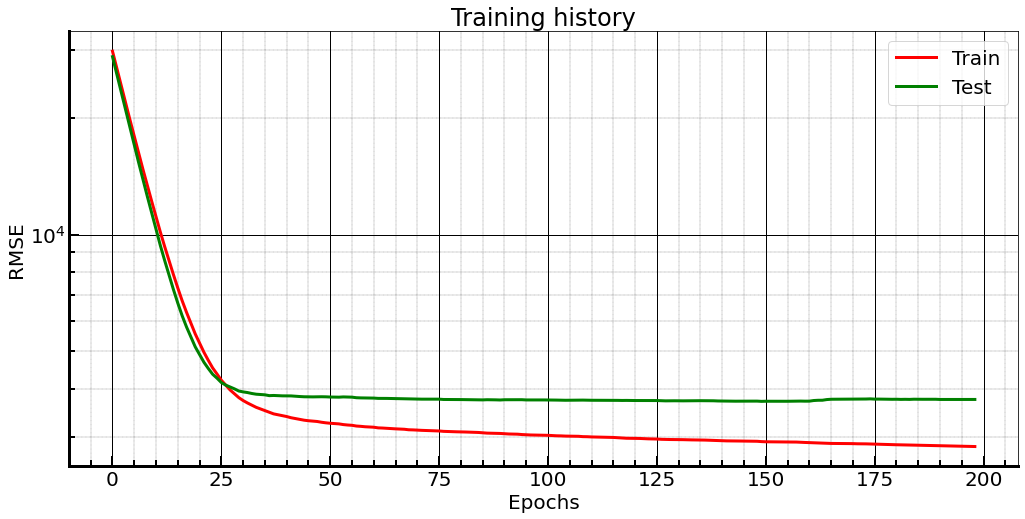

In [79]:
fig = plt.figure() 

plt.title("some title")

ax = fig.add_subplot() 

ax.plot(range(len(results['validation_0']["rmse"])), results['validation_0']["rmse"], 'r-', lw = 3, label = 'Train') 
ax.plot(range(len(results['validation_0']["rmse"])), results['validation_1']["rmse"], 'g', lw = 3, label = 'Test') 
ax.legend() 
plt.xlabel('Epochs')
plt.ylabel("RMSE")
plt.title('Training history')

ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.minorticks_on()

plt.yscale('log')
plt.show()

# Feature importance

<div class="alert alert-block alert-info">
<font color=black><br>

- Feature importance is a great way to get a general idea about which features the model is **relying on most** to make the prediction. 
- This is a metric that simply sums up how many times each feature is split on. 
- We can see that the day of year was most commonly used to split trees, while hour and year came in next. 
- **Why is quarter be given such a low importance?** This is because this can be created by different dayofyear splits.

<br></font>
</div>

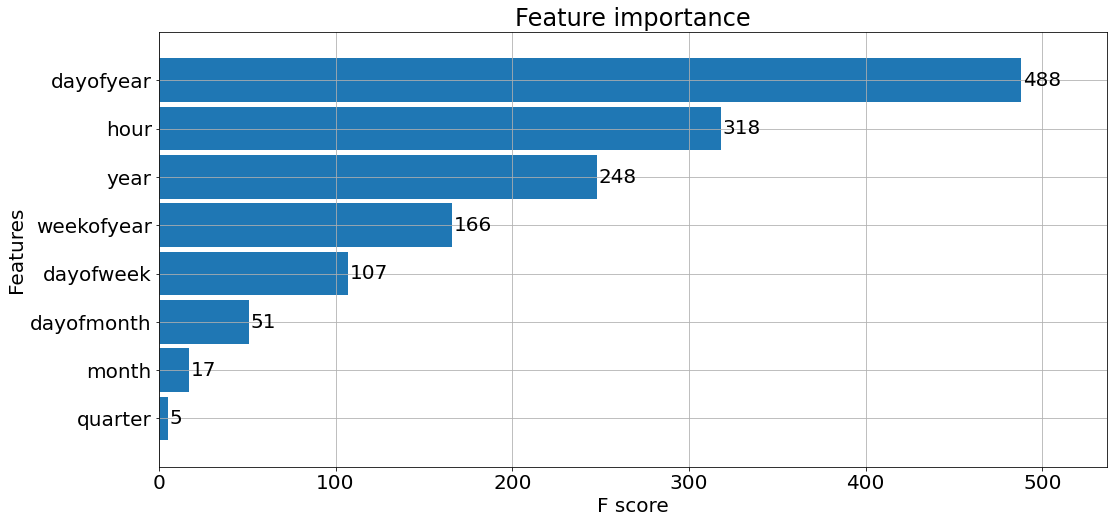

In [80]:
_ = plot_importance(reg, height=0.9)

# Forecast on Test Set

In [81]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)


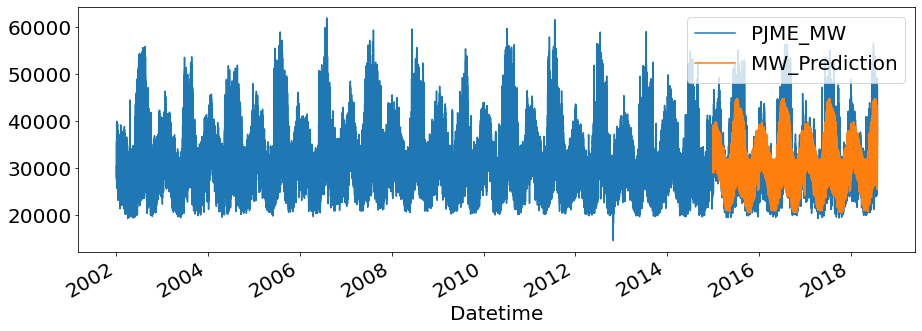

In [82]:
_ = pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

# Look at first month of predictions

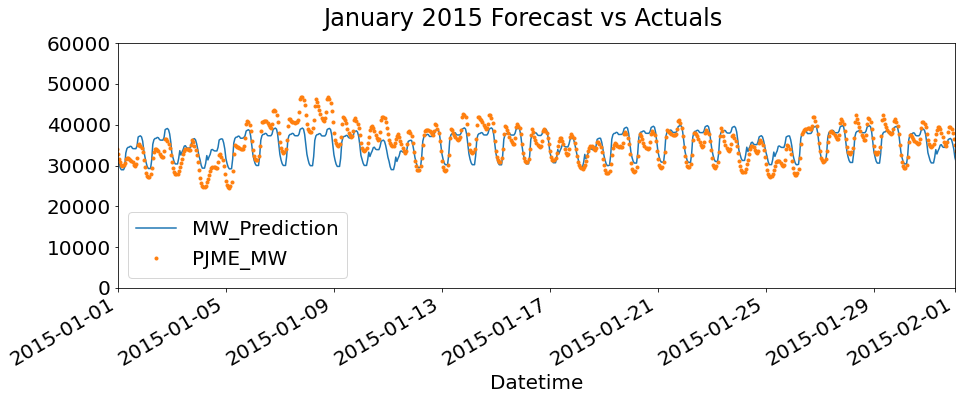

In [83]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

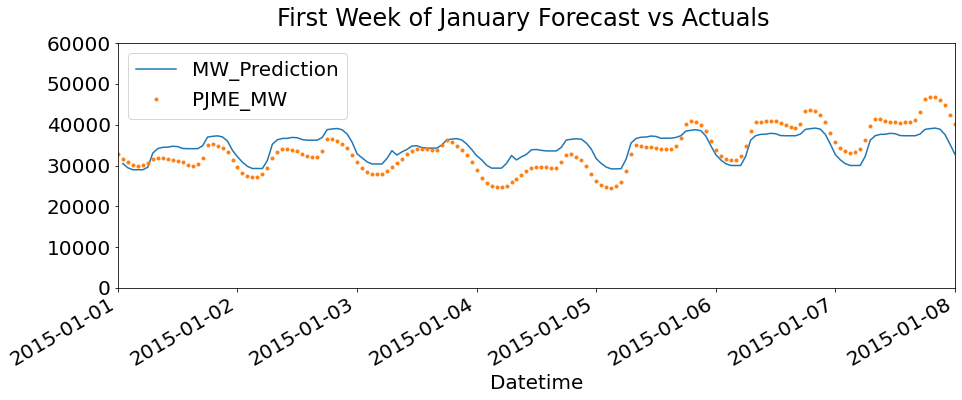

In [84]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

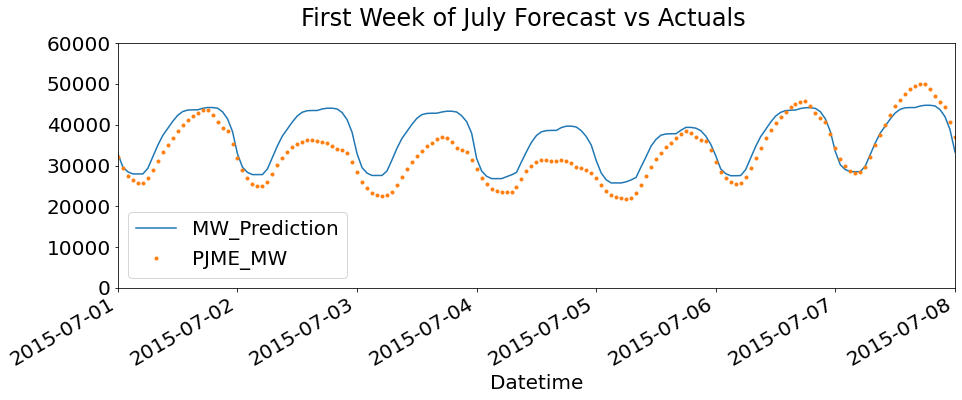

In [85]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')


# Error metrics on the test set

<div class="alert alert-block alert-info">
<font color=black><br>

- You'll see how by looking at the MSE and MAE, the numbers would not say much, unless you are an expert in the field.
- I like using mean absolute percent error because it gives an easy to interperate percentage showing how off the predictions are. 
- **MAPE** isn't included in sklearn so we need to use a custom function.

<br></font>
</div>

In [87]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

13780445.55710396

In [88]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

2848.891429322955

In [89]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [90]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

8.94944673745318

# Look at Worst and Best Predicted Days

<div class="alert alert-block alert-info">
<font color=black><br>

- Can the inspction of best and worst prediction give us insights of what we can do to improve the mode? 
- The first and second entry are holidays!
- It looks like our model could benefit from using an holiday indicator.

<br></font>
</div>

In [91]:
pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','MW_Prediction','error','abs_error']]

In [92]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2016 7     4           28399.958333   36986.964844 -8587.006429  8587.006429
2017 2     24          26445.083333   33814.503906 -7369.422445  7369.422445
2015 12    25          24466.083333   31584.923828 -7118.841390  7118.841390
2017 2     20          27070.583333   34100.781250 -7030.197754  7030.197754
2015 7     3           30024.875000   37021.031250 -6996.156169  6996.156169
2017 6     28          30531.208333   37526.589844 -6995.380371  6995.380371
     2     8           28523.833333   35511.699219 -6987.864258  6987.864258
     9     2           24201.458333   31180.390625 -6978.933105  6978.933105
     2     25          24344.458333   31284.279297 -6939.820150  6939.820150
2018 2     21          27572.500000   34477.417969 -6904.919352  6904.919352

In [93]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

PJME_MW  MW_Prediction         error     abs_error
year month dayofmonth                                                         
2016 8     13          45185.833333   31753.224609  13432.608887  13432.608887
           14          44427.333333   31058.818359  13368.514404  13368.514404
     9     10          40996.166667   29786.179688  11209.987793  11209.987793
           9           43836.958333   32831.035156  11005.923828  11005.923828
2015 2     20          44694.041667   33814.503906  10879.535889  10879.535889
2018 1     6           43565.750000   33435.265625  10130.485921  10130.485921
2016 8     12          45724.708333   35609.312500  10115.394287  10115.394287
2017 5     19          38032.583333   28108.976562   9923.606689   9923.606689
     12    31          39016.000000   29314.683594   9701.315430   9701.315430
2015 2     21          40918.666667   31284.279297   9634.388184   9634.388184

In [94]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2016 10    3           27705.583333   27775.351562  -69.768148  229.585205
2015 10    28          28500.958333   28160.875000  340.083740  388.023356
2016 10    8           25183.333333   25535.669922 -352.337402  401.017090
     5     1           24503.625000   24795.419922 -291.794515  428.289307
2017 10    29          24605.666667   24776.271484 -170.605225  474.628988
2016 9     16          29258.500000   29397.271484 -138.770833  491.070312
     3     20          27989.416667   27620.132812  369.284831  499.750488
     10    2           24659.083333   25134.919922 -475.836670  516.188232
2017 10    14          24949.583333   25399.728516 -450.145996  520.855794
2015 5     6           28948.666667   28710.271484  238.396077  546.640544

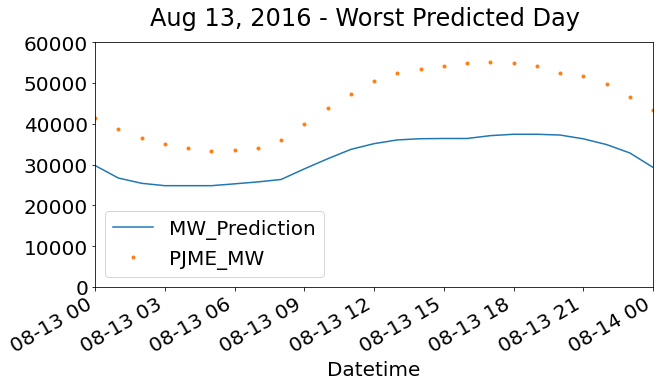

In [95]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

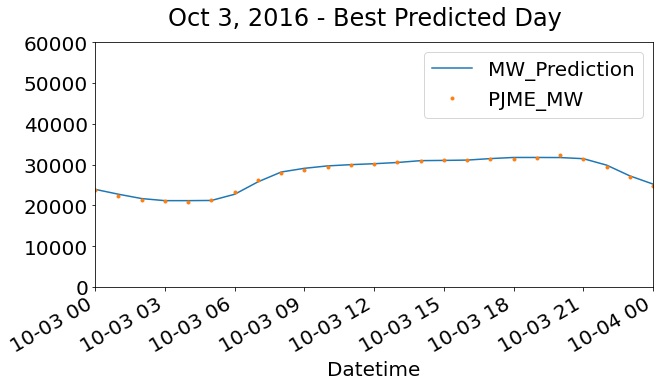

In [96]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

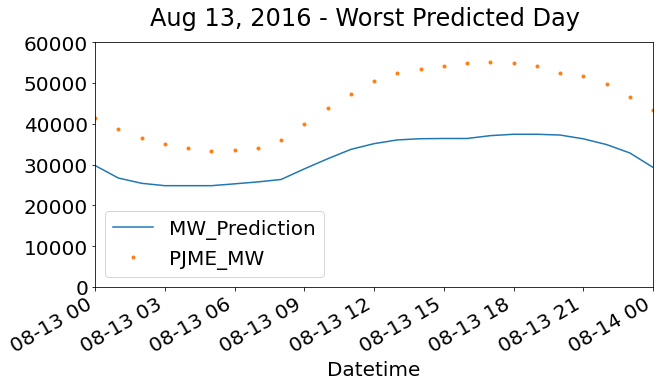

In [97]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

# References

<div class="alert alert-block alert-warning">
<font color=black><br>

- https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost
- [Link to the dataset](https://www.kaggle.com/robikscube/hourly-energy-consumption/version/3?select=PJME_hourly.csv)

<br></font>
</div>

# Conclusions